# Telco churn (final version)
This project aims to explore the telco_churn database and determine predictive factors relating to churn. The database contains quite a bit of data collected on their customers.

In [1]:
#imports
import pandas as pd
import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

import pro_acquire as acq
import pro_prepare as prep
import pro_model as pm
import knear as k
import pretty

import warnings
warnings.filterwarnings('ignore')

# Data Dictionary
| Feature | Definition |
|:--------|:-----------|
|customer_id | unique customer identifier (obj|
|tenure| how long someone has been a customer in months (int)|
|monthly_charges| how much a customer is charged monthly (float)|
|tech_support_Yes| whether or not a customer has tech support (1 for yes)|
|churn_encoded| whether or not a customer has churned (1 for yes)|
|senior_citizen_Yes| whether or not a customer is a senior citizen (1 for yes)|

# Acquire 
- Used .py embedded functions to call and prep Telco Churn dataset

# Prepare
- changed total_charges to float and set nulls to 0 (presumed customer hasn't paid yet)
- removed duplicate data contained in multiple columns
- encoded all yes or no values to numbers (0,1) for machine learning model

In [2]:
# Call data with changes made from above
train, validate, test = pretty.get_that_data()

csv file found and loaded


In [3]:
# Take a look, verify the data generated is what was expected.
train.head()

,customer_id,churn_encoded,tenure,monthly_charges,total_charges,gender_encoded,senior_citizen_encoded,partner_encoded,dependents_encoded,phone_service_encoded,...,online_backup_No internet service,online_backup_Yes,device_protection_No internet service,device_protection_Yes,tech_support_No internet service,tech_support_Yes,streaming_tv_No internet service,streaming_tv_Yes,streaming_movies_No internet service,streaming_movies_Yes
5911,8319-QBEHW,0,26,39.95,1023.75,1,0,0,1,0,...,0,1,0,0,0,0,0,1,0,0
2479,3547-LQRIK,0,47,26.90,1250.85,0,0,1,0,1,...,1,0,1,0,1,0,1,0,1,0
5889,8280-MQRQN,1,1,50.45,50.45,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
6087,8626-PTQGE,0,69,60.05,4176.70,1,0,0,0,0,...,0,1,0,0,0,1,0,1,0,1
785,1142-IHLOO,0,51,87.55,4475.90,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,1


# Explore
- I set the desired features and performed statistical analysis
    - seeking confirmation of significant relationships between the features and the target (churned)

In [4]:
#get columns to test
train[['churn_encoded','tenure','monthly_charges','senior_citizen_encoded', 'tech_support_Yes']][:5]

,churn_encoded,tenure,monthly_charges,senior_citizen_encoded,tech_support_Yes
5911,0,26,39.95,0,0
2479,0,47,26.90,0,0
5889,1,1,50.45,0,0
6087,0,69,60.05,0,1
785,0,51,87.55,0,0


# Set Target

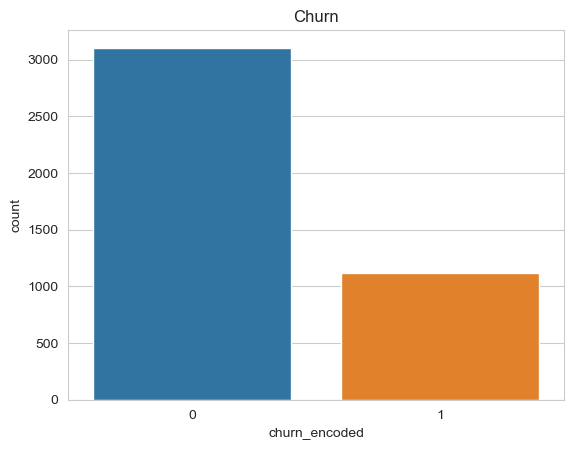

In [5]:
#plot target
pretty.plot_that_target(train)

# Do monthly charges affect churn rate?

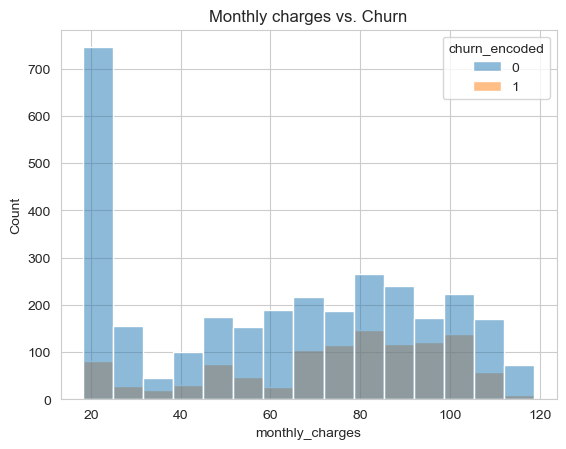

In [6]:
#plot Monthly Charges vs. Churn
pretty.plot_mcharges_v_churn(train)

ttest Results: (12.65294490503547, 1.0740986591134452e-34 0.05)

- Based on the p-value < alpha in the **ttest(one_tail)** results, we reject the null hypothesis and can infer that there is a relationship between customers paying more and whether or not a customer churns. 

# Does tenure affect churn rate?

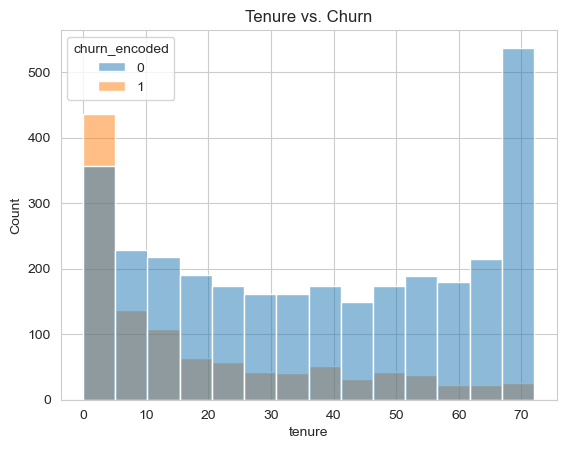

In [7]:
# Plot Tenure vs. Churn
pretty.plot_tenure_v_churn(train)

ttest results : (-24.1484254219915, 8.529422715711782e-121)

- Based on the p-value < alpha in the **ttest(two_tailed)** results, we reject the null hypothesis and can infer that there is a relationship between customer tenure and whether or not a customer churns. 

# Does whether or not someone has tech support affect churn?


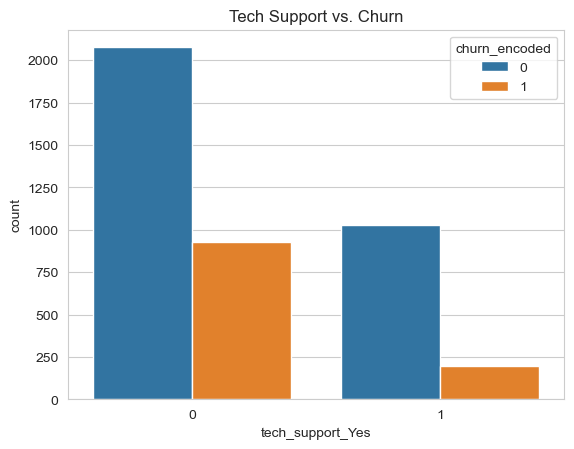

In [8]:
#Plot Tech Support vs. Churn
pretty.plot_tech_v_churn(train)

Results:
$chi^2$ = 98.2309
p = 0.0000


- Based on the p-value < alpha in the $chi^2$ results, we reject the null hypothesis and can infer that there is a relationship between having tech support and whether or not a customer churns.

# Does being a senior citizen or not affect churn?

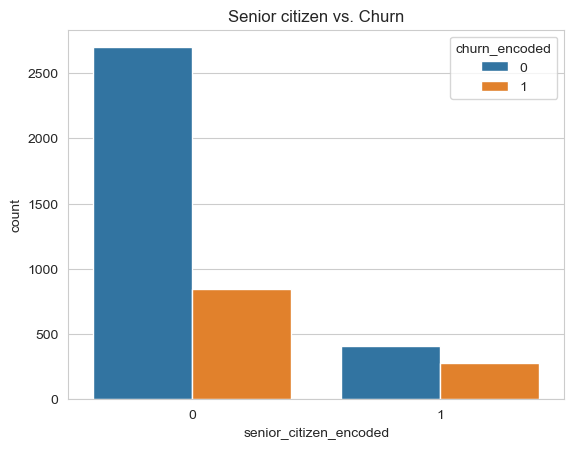

In [9]:
#Plot Senior Citizen vs. Churn
pretty.plot_senior_v_churn(train)

Results: 
$chi^2$ = 80.7936
p = 0.0000

- Based on the p-value < alpha in the $chi^2$ results, we reject the null hypothesis and can infer that there is a relationship between being a senior citizen and whether or not a customer churns.



## Exploration Summary
- Customers that Churn pay more monthly charges on average than those who do not. Mean = ~$65.00
- Customers with higher tenure churn less than customers with < ~32 months of tenure.
- Customers with tech support churned ~11% less than those without tech support.
- The customer base is only ~19% senior, however, ~68% of the senior population churns.
- All 4 independent variables are statistically significant to churn. I will use all 4 in modeling.

# Modeling

- Now that I have found significance in all of my 4 independent variables, I will model those against the target using the following models to determine the best predictive model:

    - Decision tree
    - Random forest
    - KNN
    - Logistic regression
- I have decided to use the **Accuracy** (correct prediction/over all predictions) metric. In another run of this project, I would compare models on recall scores to minimize false negatives(customers whom you have predicted would not churn but do)

In [10]:
# Split data into X_train, X_validate, X_test, y_train, y_validate, y_test
X_train, X_validate, X_test, y_train, y_validate, y_test = pretty.modeling(train, validate, test)

In [11]:
# Set baseline accuracy
(train.churn_encoded == 0).mean()

0.7346745562130178

# Decision Tree
- I ran the data through multiple decision trees ultimately discovering that max depth 4 yielded the greatest results

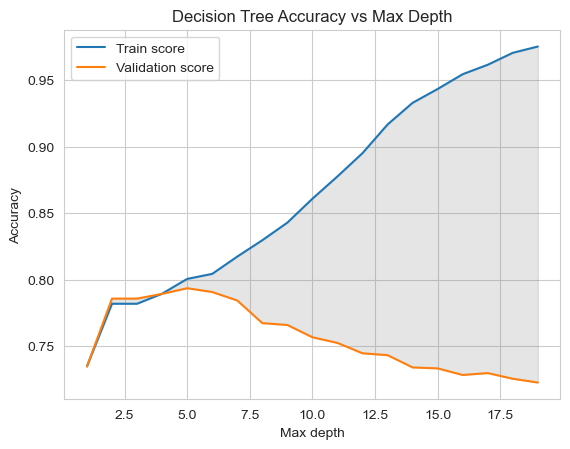

,max_depth,train_acc,val_acc,score_diff
3,4,0.789349,0.789212,0.000137


In [12]:
# Run train and validate data through Decision Tree 'for loop'.
# Call results for best performing hyperparameters.
pretty.decision_tree(X_train, X_validate, y_train, y_validate)[3:4]

- Results of max depth 4 will be used to compare to other modeling techniques.

# Random Forest
- I ran the data through many iterations of the random forest and found that leaf 5 and depth 6 yielded the greatest result.

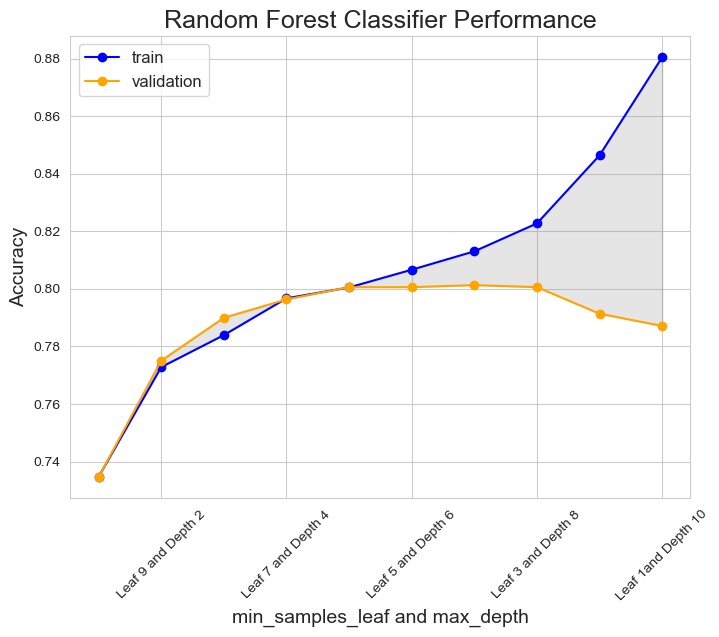

,min_samples_leaf,max_depth,train_score,validate_score,diff_score
4,5,6,0.806627,0.800568,0.006059


In [13]:
# Run train and validate data through random forest function and output a graph with the best model's metrics. 
# Call results for best performing hyperparameters.
pm.random_forest_scores(X_train, y_train, X_validate, y_validate)[4:5]

- Results of min_samples_leaf= 5 and max_depth= 6 will be used to compare to other modeling techniques.

# KNN
- I ran the data through multiple iterations of the KNN model. k = 18 yielded the greatest results.

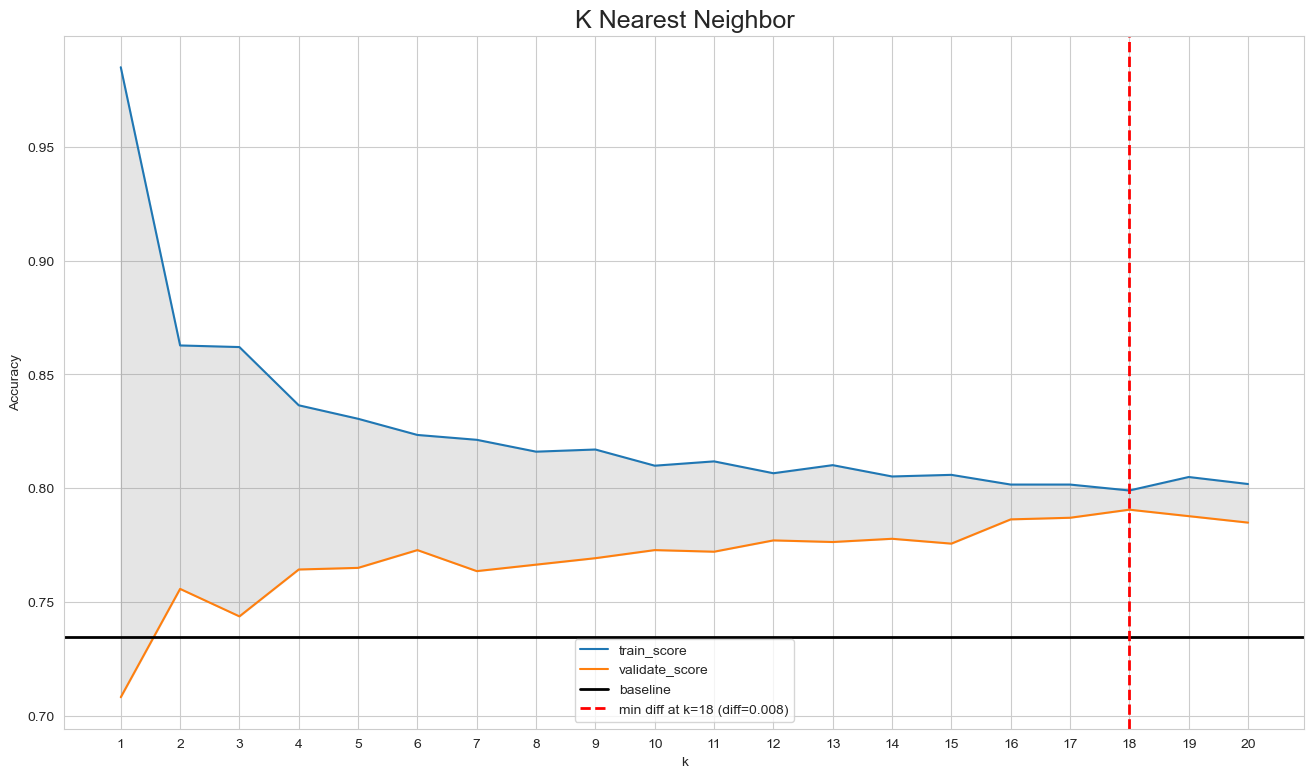

,k,train_score,validate_score,diff_score
17,18,0.799053,0.790632,0.008422


In [14]:
# Run train and validate data through KNN function and output a graph with the best model's metrics.
# Call results for best performing hyperparameters.
k.k_nearest2(X_train, y_train, X_validate, y_validate)[17:18]

- Results of k_nearest_neighbors= 18 will be used to compare to other modeling techniques.

# Logistic Regression
- I ran the data through iterations of C = 0.01, 0.1, 1, 10, 100, and 1000 

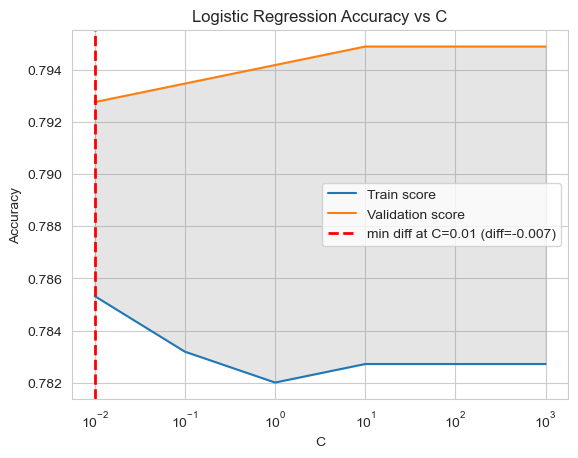

,C,train_score,validate_score,diff_score
0,0.01,0.785325,0.792761,-0.007435


In [15]:
# Run train and validate data through iterations of logistic regression
# Call results for best performing hyperparameters.
pm.plot_logistic_regression(X_train, X_validate, y_train, y_validate)[0:1]

- Results of C= 0.01 will be used to compare to other modeling techniques.

# Choose a model
- based on the following summary:
    - Baseline accuracy: 0.735
    
    - Decision Tree (max_depth = 4)
        - train: 0.78934
        - validate: 0.7892
        - difference: 0.00013
        
    - Random Forest (min_samples_leaf = 5, max_depth = 6)
        - train: 0.8066
        - validate: 0.8005
        - difference: 0.0060
        
    - KNN (k = 18)
        - train: 0.7990
        - validate: 0.7906
        - difference: 0.0084
        
    - Logistic Regression (C=0.01)
        - train: 0.7831
        - validate: 0.7934
        - difference: -0.0121
        
All models performed better than baseline. Out of the 4 models, the random forest model performed the best in both the train and validate iterations. Therefore, I chose random forest as my model of choice for this project. The test data is ran on the model below:

In [16]:
# Run selected model on test data and get predictions
rf1_score, rf1 = pretty.the_chosen_one(X_train, X_validate, X_test, y_train, y_validate, y_test)
print('Model Accuracy on test data: ', rf1_score)

Model Accuracy on test data:  0.7920511000709723


# Export predictions and probabilities to a CSV

In [17]:
#Export test predictions and probabilities to a CSV file
pretty.make_that_csv(X_test, test, rf1)

# Summary/Conclusion:
- The following data analysis pipeline categories were accomplished (Acquire, Prepare, Explore, Model)

- I selected the random forest model (5 leaf_samples and max_depth 6). The decision was made based on highest accuracy score with least amount of difference between train and validate data sets.

# Recommendations:
- All of the selected features contribute to the churn rate of Telco. I would contact my senior citizen population to question which of their needs are not being met. 
    - Having tech support seems to alleviate churn in this population. 
    - When plans are opened/renewed, we should stress the importance of tech support. 
- Monthly charges are also a driver of churn and should be further explored to ensure our customers are getting what they feel they pay for i.e.. service, reliability, availability of signal. 

# Next steps:
- With more time, further statistical analysis of the remaining features would be in the best interest of the company.
    
    - Analyzing the relationships between multiple features in relation to churn, for example.. senior citizen, no tech support and has fiber internet. Even though the selected features affect churn, their relationships to other factors may direct where we want to focus efforts.